In [1]:
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Get data from DB

from config import config

params = config()
conn = psycopg2.connect(**params)
cur = conn.cursor()
cur.execute("select * from dataentry_cifnepal as CIF inner join dataentry_personboxnepal as PB on CIF.id = PB.cif_id;")
colnames = [desc[0] for desc in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns = colnames)
cur.close()

In [3]:
# Data Processing / Create Unique Suspect ID number

dfcols = list(df.columns)
dfcols[16] = 'pv_occupation'
df.columns = dfcols

df['pb_number']=df['pb_number'].fillna(0).astype(int)
df['suspect_id'] = df['cif_number'].str.replace('.','')
df['suspect_id'] = df['suspect_id'].str[:-1] + ".PB" + df['pb_number'].map(str)
df = df.drop_duplicates(subset='suspect_id')
df.shape

(2260, 183)

In [4]:
#Remove columns that won't be used

df1 = df.drop(
    columns=[
        'id','date_time_entered_into_system','status','location','date_time_last_updated','staff_name',
        'informant_number','case_notes', 'pv_signed_form', 'consent_for_fundraising', 'guardian_name', 
        'guardian_phone', 'social_media', 'permission_contact_pv', 'permission_contact_whats_app', 
        'permission_contact_facebook', 'permission_contact_phone', 'legal_action_taken_filed_against', 
        'officer_name', 'cif_id', 'person_id', 'flag_count', 'main_pv_id', 'expected_earning',
        'expected_earning_currency','travel_expenses_paid_to_broker_amount','broker_relation',
        'travel_expenses_broker_repaid_amount','form_entered_by_id', 'source_of_intelligence', 
        'date_time_last_updated','interview_date','incident_date','how_recruited_broker_other',
        'legal_action_taken','legal_action_taken_case_type','appearance','date_visit_police_station',
        'victim_statement_certified_date','purpose_for_leaving_other','relation_to_pv',
        'exploitation_forced_prostitution_lb','exploitation_sexual_abuse_lb','exploitation_physical_abuse_lb',
        'exploitation_debt_bondage_lb','exploitation_forced_labor_lb','associated_lb',
        'exploitation_organ_removal_lb','exploitation_other_value','exploitation_other_lb',
    ])
df1.shape

(2260, 132)

In [5]:
#Add Arrest data

Arrests = pd.read_csv("Arrests.csv")
df1 = pd.merge(df1, Arrests, how='outer',on='suspect_id', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('x', 'y'), copy=True, indicator=False,
         validate=None)
df1.Arrest=df1.Arrest.fillna('0').astype(int)
df1 = df1.dropna(axis=0, subset=['cif_number'])

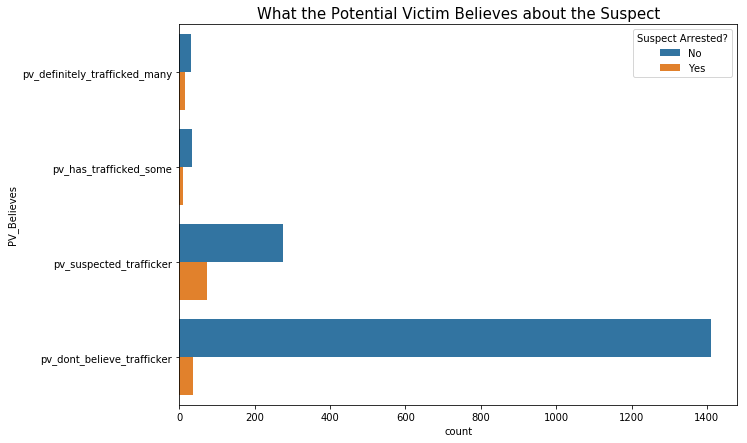

In [6]:
#EDA
#Look at total arrests by "potential victim believes" response

df2 = df1[['pv_definitely_trafficked_many', 'pv_has_trafficked_some', 'pv_suspected_trafficker', 
           'pv_dont_believe_trafficker', 'Arrest']]
df2 = pd.melt(df2, id_vars = ['Arrest'], value_vars = ['pv_definitely_trafficked_many', 'pv_has_trafficked_some', 
                                                       'pv_suspected_trafficker', 'pv_dont_believe_trafficker'],
                   var_name='PV_Believes', value_name='PV_BVal')
df2 = df2[df2.PV_BVal]

from matplotlib import pyplot

pdim=(10,7)
fig, ax = pyplot.subplots(figsize=pdim)
g = sns.countplot(ax=ax,y="PV_Believes", hue="Arrest",
                data=df2);
g.set_title("What the Potential Victim Believes about the Suspect",fontsize=15)
leg = g.get_legend()
leg.set_title("Suspect Arrested?")
labs = leg.texts
labs[0].set_text("No")
labs[1].set_text("Yes")

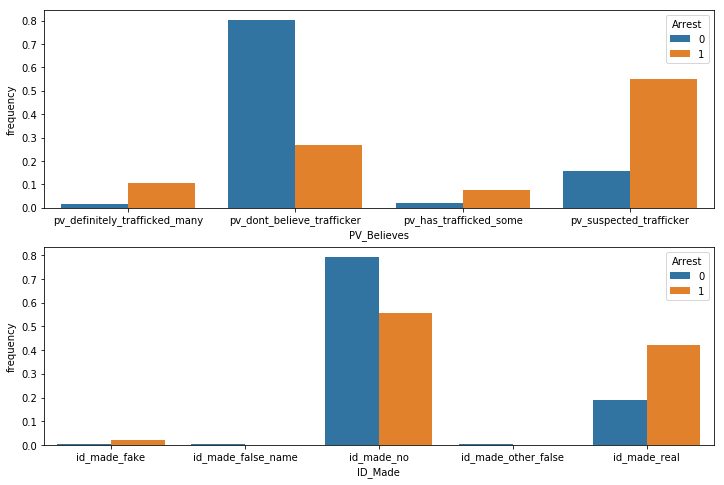

In [7]:
#EDA
#Look at percentage of arrests by "potential victim believes" and "ID Made" responses

df3 = pd.melt(df1, id_vars =['Arrest'], value_vars =['id_made_no','id_made_real','id_made_fake','id_made_false_name',
                                                     'id_made_other_false'],
              var_name='ID_Made', value_name='ID_Val')
df3 = df3[df3.ID_Val]
df2 = df2.set_index(['Arrest', df2.groupby('Arrest').cumcount()])
df3 = df3.set_index(['Arrest', df3.groupby('Arrest').cumcount()])
df4 = (pd.concat([df2, df3],axis=1)
         .sort_index(level=1)
         .reset_index(level=1, drop=True)
         .reset_index())

fig, axes = plt.subplots(2,1, figsize=(12,8))

df4['frequency'] = 0
for col, ax in zip(['PV_Believes','ID_Made'], axes.flatten()):
    counts = df4.groupby([col,'Arrest']).count()
    freq_per_group = counts.div(counts.groupby('Arrest').transform('sum')).reset_index()
    sns.barplot(x=col,y='frequency', hue='Arrest',data=freq_per_group,ax=ax)

In [8]:
#Feature Engineering

df1['planned_destination'] = df1['planned_destination'].str.replace(r'[^\w\s]+', '')
df1['destination_gulf'] = np.where(df1['planned_destination'].str.contains(
    'Gulf|Kuwait|Dubai|UAE|Oman|Saudi|Iraq|Qatar|Bahrain'),True,False)
df1['destination_unknown'] = np.where(df1['planned_destination'].str.contains('know'),True,False)

dest = ['Nepal','India','Delhi','Gorakhpur','Bihar','Mumbai','Sunauli','Banaras','Kolkata']
for d in dest:
    df1['destination_' + str(d)] = np.where(df1['planned_destination'].str.contains(d),True,False)

PB_fields = ['id_source_pb','recruited_agency_pb','recruited_broker_pb','how_recruited_broker_online_pb',
             'exploitation_sexual_abuse_pb','how_recruited_broker_approached_pb', 'known_broker_pb',
             'expected_earning_pb','exploitation_forced_prostitution_pb','exploitation_forced_labor_pb',
             'exploitation_organ_removal_pb','exploitation_other_pb','married_broker_pb',
             'travel_expenses_paid_by_broker_pb','travel_expenses_paid_by_broker_repaid_pb',
             'travel_expenses_paid_to_broker_pb','exploitation_physical_abuse_pb','exploitation_debt_bondage_pb']

def func(x):
    return str(x[0]) in list(str(x[1]))

df1.pb_number = df1.pb_number.fillna(0)
df1.pb_number = df1.pb_number.astype(int)

for PBf in PB_fields:
    df1[PBf + "2"] = df1[['pb_number', PBf]].apply(func, axis=1)

df1 = df1.drop(columns=['planned_destination','pb_number'])
df1 = df1.drop(columns = PB_fields)

In [9]:
#Organizing/preprocessing data

numerical_features = ['number_of_victims','number_of_traffickers','known_broker_years', 'known_broker_months',
                      'married_broker_years', 'married_broker_months','reported_blue_flags','total_blue_flags',
                      'suspected_trafficker_count']

categorical_features = ['education','guardian_relationship','station_id','role','pv_occupation','occupation']

boolean_features = list(
    set(list(df1.columns)) - set(numerical_features) - set(categorical_features)
)

df1[boolean_features] = df1[boolean_features].astype(bool)

df1[numerical_features] = df1[numerical_features].fillna(0).astype(float)

for f in categorical_features:
    df1[f] = df1[f].astype("category")

for cf in categorical_features:
    for elem in df1[cf].unique():
        df1[str(cf) + "_" + str(elem)] = df1[str(cf)] == elem
df1 = df1.drop(columns = categorical_features)

In [10]:
from sklearn.model_selection import train_test_split

X = (df1.drop(columns=['Arrest','Arrest_Date','cif_number','suspect_id']))
y = df1.Arrest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.125)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [12]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('scaler', StandardScaler()),
        ]))
    ])),
])

In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


cls_pipeline = Pipeline([
    ('transformer', transformer),
    ('clf', SGDClassifier())
])

cls_pipeline.fit(X_train, y_train)
y_sgd = cls_pipeline.decision_function(X_validation)

cls_pipeline.set_params(clf=RandomForestClassifier())
cls_pipeline.fit(X_train, y_train)
y_rf = cls_pipeline.predict_proba(X_validation)

C:\Users\RandA\Anaconda3\envs\py36_32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\RandA\Anaconda3\envs\py36_32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


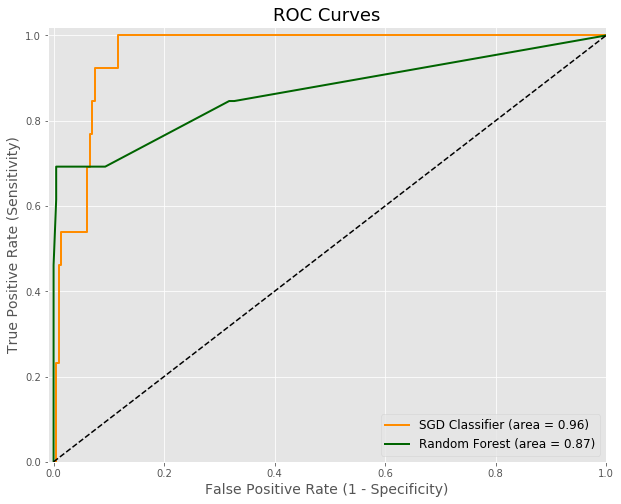

In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_validation, y_sgd)
roc_auc = auc(fpr, tpr)

rf_fpr, rf_tpr, thresholds = roc_curve(y_validation, y_rf[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='SGD Classifier (area = %0.2f)' % roc_auc)
plt.plot(rf_fpr, rf_tpr, color='darkgreen',
         lw=2, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curves', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV
from time import time

search_space = [{'clf': [SGDClassifier()],
                 'clf__alpha': (0.00001, 0.000001),
                 'clf__penalty': ['l1','l2', 'elasticnet'],
                 'clf__learning_rate': ['optimal','adaptive'],
                 'clf__eta0': (0.00001, 0.000001),
                 'clf__class_weight': ['balanced',None]},
                {'clf': [RandomForestClassifier()],
                 'clf__bootstrap': [False, True],
                 'clf__n_estimators': [10,100],
                 'clf__min_samples_split': [3, 5, 7],
                 'clf__max_features': [0.5, 0.6, 0.7, 0.8, 1],
                 'clf__class_weight': ["balanced","balanced_subsample",None]}]
        
                 #'clf__min_samples_leaf': [10, 12, 15, 20, 50],


if __name__ == "__main__":
    grid_search = GridSearchCV(cls_pipeline, search_space, cv=5, n_jobs=-1,verbose=1)

    print("Performing grid search...")
    print("parameters:")
    print(search_space)
    t0 = time()
    best_model=grid_search.fit(X_train,y_train)
    print("done in %0.3fs" % (time() - t0))
    print()
    best_parameters = best_model.best_estimator_.get_params()['clf']
    
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    print(best_parameters)

Performing grid search...
parameters:
[{'clf': [SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)], 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ['l1', 'l2', 'elasticnet'], 'clf__learning_rate': ['optimal', 'adaptive'], 'clf__eta0': (1e-05, 1e-06), 'clf__class_weight': ['balanced', None]}, {'clf': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
         

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1140 out of 1140 | elapsed: 12.2min finished
C:\Users\RandA\Anaconda3\envs\py36_32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 735.223s

Best score: 0.941
Best parameters set:
RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=1,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


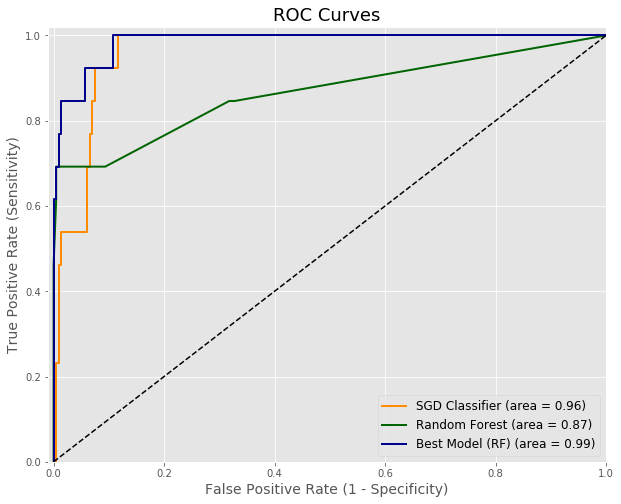

In [16]:
y_rf_best = best_model.predict_proba(X_validation)

fpr, tpr, thresholds = roc_curve(y_validation, y_sgd)
roc_auc = auc(fpr, tpr)

rf_fpr, rf_tpr, thresholds = roc_curve(y_validation, y_rf[:, 1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

rf_best_fpr, rf_best_tpr, thresholds = roc_curve(y_validation, y_rf_best[:, 1])
rf_best_roc_auc = auc(rf_best_fpr, rf_best_tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='SGD Classifier (area = %0.2f)' % roc_auc)
plt.plot(rf_fpr, rf_tpr, color='darkgreen',
         lw=2, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(rf_best_fpr, rf_best_tpr, color='darkblue',
         lw=2, label='Best Model (RF) (area = %0.2f)' % rf_best_roc_auc)
#plt.plot(cv_rf_fpr, cv_rf_tpr, color='blue',
#         lw=2, label='Random Forest CV (area = %0.2f)' % cv_rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate (1 - Specificity)', size=14)
plt.ylabel('True Positive Rate (Sensitivity)', size=14)
plt.title('ROC Curves', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.show()